# Building Face Recognition Model using ArcFace


In [ ]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file

np.set_printoptions(3)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

ms_dir = "../../data/ms-celeb-1m/"

# \[ ARCFACE를 활용한 얼굴인식 모델 구성하기 \]
---

## 1. `ResNet50`을 통한 특징 추출 모델 만들기

### (1) Backbone 층 구성하기

ImageNet Weight를 이용하지 않습니다.

In [ ]:
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(include_top=False,weights=None, 
                      input_shape=(112,112,3))

###  (2) Classifier 층 구성하기 

In [ ]:
from tensorflow.keras.layers import ReLU, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

num_classes = len(os.listdir(ms_dir))
num_embed = 512

x = BatchNormalization(name='embed_before_bn')(backbone.output)
x = Dropout(.4, name='dropout')(x)
x = Flatten()(x)
x = Dense(num_embed, use_bias=False, name='embed')(x)
x = BatchNormalization(name='embed_after_bn')(x)

### (3) ARCFACE 층 구성하기

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ArcFace(Layer):
    def __init__(self, num_classes, 
                 scale=64, margin=0.5, **kwargs):
        self.num_classes = num_classes
        self.scale = scale
        self.margin = margin
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        self.w = self.add_weight(
            name='weight', trainable=True,
            shape=(input_shape[0][-1], self.num_classes))
        super().build(input_shape)
    
    @tf.function
    def call(self, inputs):
        assert isinstance(inputs, list) or isinstance(inputs, tuple)
        # Last Convolution Layers output and Ground Truth Label
        features, labels = inputs
        
        # (1) 각 클래스 별로 코사인 유사도 구하기
        norm_feat = tf.linalg.l2_normalize(features, axis=1)
        norm_weight = tf.linalg.l2_normalize(self.w, axis=0)
        cosine = norm_feat @ norm_weight
        # 이미지와 특정 클래스와의 유사도가 높을수록 해당 값이 1에 가까워지고
        # 낮을 수록 -1에 가까워짐
        
        # (2) acos을 통해 theta값 구하기

        # acos란? cosine의 역함수.
        # 주의할 점 : 
        # acos은 -1.~1.값 범위 외 input이 들어올 시 NaN 값 반환하기 때문에
        # 값의 범위를 잡아주어야 함.
        cosine = tf.clip_by_value(cosine, -1.+1e-7, 1.-1e-7) 
        theta = tf.math.acos(cosine)
        
        # (3) GT Class에 해당하는 Theta에만 Margin을 부여
        one_hot = tf.one_hot(labels, self.num_classes,
                             True, False, axis=-1) 
        margin_theta = tf.where(one_hot, theta + self.margin, theta)
        margin_theta = tf.clip_by_value(margin_theta, 0., np.pi)
        
        # (4) Cosine 값으로 복원 후, Scaling (보통 64)
        logits = self.scale * tf.math.cos(margin_theta)
        return logits
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "scale": self.scale,
            "margin": self.margin
        })
        return config

In [ ]:
from tensorflow.keras.layers import Input

num_classes = len(os.listdir(ms_dir))
scale = 64
margin = 0.3

labels = Input(shape=(), dtype=tf.int32, name='labels')
outputs = ArcFace(num_classes, scale, margin)([x, labels])

### (3) 모델로 구성하기

In [ ]:
from tensorflow.keras.models import Model

model = Model([backbone.input, labels], outputs)

## 2. 모델 컴파일하기

### (1) Weight Decay 항 추가하기

In [ ]:
l2_reg = 5e-4
l2_loss = K.sum(
    [l2_reg*K.sum(weight**2) 
     for weight in model.trainable_weights 
     if "kernel" in weight.name])
model.add_loss(lambda : l2_loss)

### (2) 옵티마이저와 손실함수 결정하기

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import metrics

model.compile(
    SGD(1e-1, momentum=0.9, nesterov=True), 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        metrics.SparseCategoricalAccuracy(),
        metrics.SparseCategoricalCrossentropy(from_logits=True),
        metrics.SparseTopKCategoricalAccuracy(k=10)])

## 3. 데이터 구성하기

### (1) 파일 읽어오기

In [ ]:
import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

fpaths = glob.glob(os.path.join(ms_dir,"*/*.jpg"))
fpaths = shuffle(fpaths)

fnames = [path.split('/')[-2] for path in fpaths]
names, labels = np.unique(fnames, return_inverse=True)

### (2) `tf.data`로 불러들이기

In [ ]:
@tf.function
def preprocess(fpath, label):
    file = tf.io.read_file(fpath)
    image = tf.image.decode_image(file, channels=3, dtype=tf.float32,
                                  expand_animations=False)
    image = tf.image.resize(image, (112,112))
    return (image, label), label

trainset = (tf.data.Dataset
            .from_tensor_slices((fpaths, labels))
            .map(preprocess)
            .shuffle(10000)
            .batch(512)
            .prefetch(-1))

## 3. 모델 학습하기

In [ ]:
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger

LOG_DIR = os.path.join(
    "./logs/", datetime.now().strftime('%m%d-%H%M'))
os.makedirs(LOG_DIR, exist_ok=True)

callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='loss', patience=30),
    ModelCheckpoint(os.path.join(LOG_DIR,"{epoch:02d}-{loss:.4f}.h5"),
                    save_best_only=True),
    CSVLogger(os.path.join(LOG_DIR,'training.log')),
    TensorBoard(LOG_DIR)]

In [ ]:
history = model.fit(trainset, epochs=50, callbacks=callbacks)

# [ 예제 데이터 : LFW Pairs ] 
---

[Label Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) 데이터는 얼굴 인식 영역에서 모델 성능을 평가하는 데이터셋으로 널리 쓰이고 있습니다. 2장의 얼굴을 넣어서, 두 얼굴이 동일한지 아닌지를 평가하는 식으로 진행합니다.

## 1. 데이터셋 가져오기

In [7]:
def read_lfw_pairs(bin_path, image_size=(112, 112)):
    with open(bin_path, 'rb') as f:
        bins, labels = pickle.load(f, encoding='bytes')
    labels = np.array(labels)
    
    data = np.empty(
        (len(labels)*2, *image_size, 3),np.uint8)
    
    for i in range(len(labels)*2):
        bin_ = bins[i]
        img = cv2.imdecode(bin_, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        data[i, ...] = img
    
    left_images, right_images = data[::2], data[1::2]
    
    return (left_images, right_images), labels

In [8]:
lfw_path = get_file("./lfw.bin",
                    'https://pai-datasets.s3.ap-northeast-2.amazonaws.com/face-recognition/lfw.bin')
(left_images, right_images), labels = read_lfw_pairs(lfw_path)

#### 이미지 수 

In [9]:
print("각 데이터의 Shape\n")
print("* left_images : ", left_images.shape)
print("* right_images : ", right_images.shape)
print("* labels : ", labels.shape)

각 데이터의 Shape

* left_images :  (6000, 112, 112, 3)
* right_images :  (6000, 112, 112, 3)
* labels :  (6000,)


## 2. 데이터 시각화

In [10]:
sample_indices = np.random.choice(np.arange(len(labels)),5)

left_samples = left_images[sample_indices]
right_samples = right_images[sample_indices]
label_samples = labels[sample_indices]

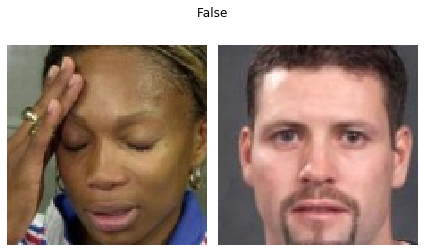

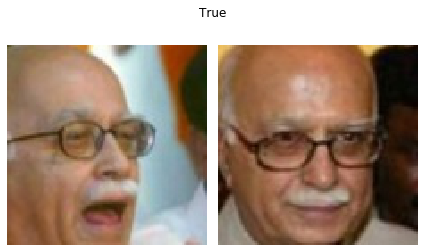

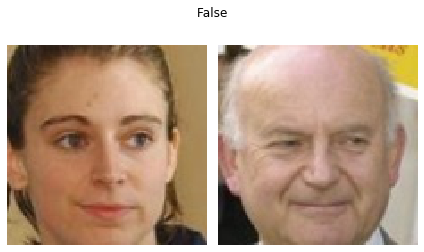

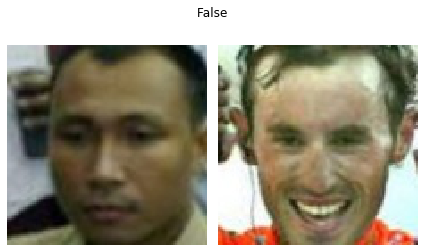

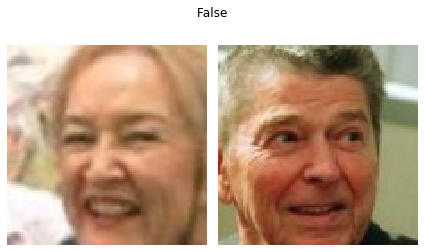

In [11]:
for left, right, label in zip(left_samples, right_samples, label_samples):
    fig = plt.figure()
    fig.suptitle(label)
    
    ax = fig.add_subplot(1,2,1)
    ax.imshow(left); ax.axis('off')    

    ax = fig.add_subplot(1,2,2)
    ax.imshow(right); ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# [Face Recognition에서의 Evaluation ] 
---

## 1. Confusion Matrix

Confusion Matrix란 분류 모델의 성능을 평가하기 위한 가장 기본이 되는 행렬입니다.

<img src="https://i.imgur.com/9uGE2UL.png" width="500">

위의 정보가 있으면 우리는 여러가지 기준으로 모델을 평가할 수 있습니다.

### (1) Accuracy 

전체적으로 이 분류기가 얼마나 잘 맞추었는지를 평가할 때 쓰입니다.

$$
accuracy = \frac{TP+TN}{TP+FN+FP+TN}
$$

### (2) Error Rate

얼마나 자주 틀렸는지를 평가할 때 쓰입니다. 주로 "Error가 20% 감소하였습니다."와 같이 이야기할 때 쓰이는 수치입니다.
$$
error\ rate = \frac{FP+FN}{TP+FN+FP+TN} = 1 - accuracy
$$

### (3) Recall(Sensitivity, 재현율)
실제 정답 중 모델에서 올바르게 분류한 비율을 의미합니다. 암세포 검출 등 놓치면 안되는 분류 문제에 있어서는 Recall을 매우 높게 설정해야 합니다.

$$
recall = \frac{TP}{TP+FN}
$$

### (4) Precision(정밀도)
모델이 예측한 정답 중 실제 정답의 비율을 의미합니다. 정밀도가 높을수록, False Alarm 문제가 적게 발생합니다.

$$
precision = \frac{TP}{TP+FP}
$$

## 2. TAR(True Accept Rate)와 FAR(False Accept Rate)

생체 인증 시스템을 설계할 때 가장 많이 사용하는 지표는 바로 TAR와 FAR 입니다. 

Face Verification의 경우, 우리는 두 이미지의 임베딩 유사도가 **특정 기준**을 바탕으로 넘으면 두 얼굴이 동일인물이라고 인식하고, 넘지 못하면 두 얼굴이 다른 인물이라고 인식하게 됩니다. 어떻게 **특정 기준**을 정의하는가가 매우 중요한 이슈가 됩니다.

생체 인증의 경우, 잘못 인식해서 타인의 얼굴로 인해 보안이 해제된다면 매우 심각해 집니다. 이 경우에는 **특정 기준**이 매우 높을수록 안전한 모형이 될 것입니다. 대신 보안이 중요하지 않은 서비스에서 **특정 기준**이 지나치게 높으면, 정상적인 경우에도 생체 인증이 잘 먹히지 않아 불편한 경험을 할 것입니다. 그래서 단순히 Accuracy를 이용한 평가 외에도 TAR와 FAR을 이용한 평가가 필요합니다.

#### FAR이란?

False Cases에서 Positive로 나온 비율을 의미합니다.

$$
FAR = \frac{FP}{FP+TN}
$$

#### TAR이란?

True Cases에서 Positive로 나온 비율을 의미합니다.

$$
TAR = \frac{TP}{TP+FN}
$$

# [ Face Verifcation 수행하기 ]
---

## 1. 임베딩 모델 가져오기

### (1) ArcFace Layer 구성하기

CustomLayer은 Keras에 등록해야지 모델을 불러올 수 있습니다.

In [12]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ArcFace(Layer):
    def __init__(self, num_classes, 
                 scale=64, margin=0.5, **kwargs):
        self.num_classes = num_classes
        self.scale = scale
        self.margin = margin
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        self.w = self.add_weight(
            name='weight', trainable=True,
            shape=(input_shape[0][-1], self.num_classes))
        super().build(input_shape)
    
    @tf.function
    def call(self, inputs):
        assert isinstance(inputs, list) or isinstance(inputs, tuple)
        features, labels = inputs
    
        norm_feat = tf.linalg.l2_normalize(features, axis=1)
        norm_weight = tf.linalg.l2_normalize(self.w, axis=0)
        cosine = norm_feat @ norm_weight
        cosine = tf.clip_by_value(cosine, -1.+1e-7, 1.-1e-7) 
        theta = tf.math.acos(cosine)
        
        one_hot = tf.one_hot(labels, self.num_classes,
                             True, False, axis=-1) 
        margin_theta = tf.where(one_hot, theta + self.margin, theta)
        margin_theta = tf.clip_by_value(margin_theta, 0., np.pi)
        
        logits = self.scale * tf.math.cos(margin_theta)
        return logits
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "scale": self.scale,
            "margin": self.margin
        })
        return config

### (2) 학습된 모델 불러오기

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

fpath =  get_file("arcface_model.h5",
                  "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/face-recognition/arcface_model.h5")
model = load_model(fpath, custom_objects={'ArcFace':ArcFace})

img_input = model.input[0]
embed_output = model.get_layer('embed').output

embed_model = Model(img_input, embed_output)

704831488/704824112 [==============================] - 12s 0us/step


### (3) 모델을 통한 Embedding 행렬 구하기

In [14]:
left_embeds = embed_model.predict(left_images/255.)
right_embeds = embed_model.predict(right_images/255.)

### (4) 임베딩 유사도 계산하기

In [15]:
preds = []
for (left_embed, right_embed) in zip(left_embeds, right_embeds):
    similarity = (
        left_embed@right_embed / 
        (np.linalg.norm(left_embed) * np.linalg.norm(right_embed)))
    preds.append(similarity)
preds = np.array(preds)

## 2. 모델 평가하기

### (1) ROC_CURVE 그리기

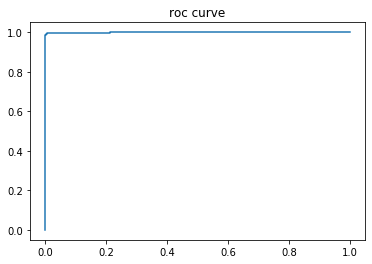

In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels, preds)

plt.title("roc curve")
plt.plot(fpr, tpr)
plt.show()

### (2) Accuracy 구하기 

각 Cut value 별로 정확도가 다릅니다. 우리는 cut value별로 Accuracy중 가장 높은 Accuracy를 기록한 결과를 이용할 예정입니다.

In [17]:
best_acc = 0
best_thr = 0
for thr in thresholds:
    acc = np.mean((preds>thr)==labels)
    if acc > best_acc:
        best_thr = thr
        best_acc = acc
print("cut value :{:.3f} 일 때, 정확도 : {:.1%}".format(best_thr, best_acc))

cut value :0.313 일 때, 정확도 : 99.4%


## 3. 생체 인증 시스템의 평가 기준, (TAR@FAR)

생체 인증 시스템의 평가지표로는 위와 같은 `TAR @ FAR=0.001` 지표를 많이 이용합니다. 이 지표의 의미는 FAR=0.001가 되는 Threshold에서 TAR이 얼마나 높게 나오는가?를 의미합니다. Accuracy가 매우 높게 나오더라도, TAR @ FAR은 얼마든지 낮게 나올 수 있습니다. 


### (1) `TAR@FAR=0.001`

In [18]:
threshold = 1e-3

negative_cases = (labels==False)

cut_value = np.quantile(preds[negative_cases], 1-threshold)

positive_cases = (labels==True)
tar = np.mean(preds[positive_cases]>cut_value)
tar

0.986

### (2) `TAR@FAR=0.01`

In [19]:
threshold = 1e-2

negative_cases = (labels==False)

thr = np.quantile(preds[negative_cases], 1-threshold)

positive_cases = (labels==True)
tar = np.mean(preds[positive_cases]>thr)
tar

0.9936666666666667

### (3) `TAR@FAR=0.1`

In [20]:
threshold = 1e-1

negative_cases = (labels==False)

thr = np.quantile(preds[negative_cases], 1-threshold)

positive_cases = (labels==True)
tar = np.mean(preds[positive_cases]>thr)
tar

0.9976666666666667